In [1]:
### %reload_ext autoreload

###%reset

import numpy as np
import torch as torch

import scipy.interpolate
import scipy.special
from scipy.stats import poisson
from scipy.stats import uniform
from astropy import units

import matplotlib.pyplot as pl
import matplotlib

import healpy as hp
from astropy import units as u

#For making corner plots
from getdist import plots, MCSamples

import pdb
import time

import sys
sys.path.append('..')
import LFI_galactic as LFIg
import subhalos as subs
import FermiBackgrounds
import DMsignal

import pickle as pk

import elfi
from elfi.methods.density_ratio_estimation import DensityRatioEstimation
#import graphviz
elfi.set_client('multiprocessing')
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True

import abc_funcs as af

matplotlib.use('PS')

%matplotlib inline

/home/chri3448/.conda/envs/env_healpy/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
channel = 'Tau'
run = 'generate'

#For data generation
logbins = False
if (run == 'generate'):
    load_pf = True
    load_data = False
    save_data = True
    save_posterior = True
    include_bg = True
    vary_DMmass = False
    N_E_bins = 10
    cmax_summary = 250
    
# Comparison to exact likelihood
if (run == 'run1'):
    load_pf = True
    load_data = True
    save_data = False
    save_posterior = True
    include_bg = True
    vary_DMmass = False
    N_E_bins = 1
    nbins_summary = 20
    cmax_summary = 240
    max_iter = 5 #5
    
# Showing that adding energy info helps
if (run == 'run2'):
    load_pf = True
    load_data = True
    save_data = False
    save_posterior = True
    include_bg = True
    vary_DMmass = False
    if (channel == 'Tau'):
        N_E_bins = 10
        nbins_summary = 15
        cmax_summary = 75
        max_iter = 5
    if (channel == 'b'):
        N_E_bins = 10
        nbins_summary = 10
        cmax_summary = 120 
        max_iter = 1

# Varying DM mass as well
if (run == 'run3'):
    load_pf = True
    load_data = True
    save_data = False
    save_posterior = True
    include_bg = True
    vary_DMmass = True
    N_E_bins = 10
    nbins_summary = 15
    cmax_summary = 75 # 70 - for tau
    max_iter = 4 #4

if (channel == 'Tau'):
    if (run == 'run3'):
        normalize_mean = [200., 1., 200000.]
        normalize_std = [100.0, 0.01, 10000.0]    
    else:
        normalize_mean = [0.0, 0.0, 0.0]
        normalize_std = [1.0, 1.0, 1.0] 
        
if (channel == 'Tau'):
    suffix = 'tau_default_NE10_MMin1_10yr_isotropic_rmin0'
if (channel == 'b'):
    suffix = 'b_default_NE10_MMin1_10yr_isotropic_rmin0'

In [3]:
#parameter ranges
DM_directory = '../data/dm_spectra/'
my_DM = DMsignal.DMsignal(DM_directory, channel)
default_param_dict = my_DM.get_default_model()
default_params = np.array([default_param_dict['A_DM'],\
                           default_param_dict['A_BG'],\
                           default_param_dict['mass_DM_MeV']])
print("default params = ", default_param_dict)

if (channel == 'Tau'):    
    param_min_all = np.array([0.2, 0.99, 0.1])*default_params
    param_max_all = np.array([2.5, 1.01, 1.9])*default_params                
if (channel == 'b'):
    param_min_all = np.array([0.4, 0.993, 0.1])*default_params
    param_max_all = np.array([1.7, 1.007, 1.9])*default_params  

param_min_all_norm = af.params_to_norm(param_min_all, normalize_mean, normalize_std)
param_max_all_norm = af.params_to_norm(param_max_all, normalize_mean, normalize_std)
print(param_min_all_norm)
print(param_max_all_norm)

param_names_all = np.array(['ADM', 'bgnorm', 'MDM'])
param_labels_all = np.array(['\\A_{DM}', '\\A_{\rm bg}', '\\M_{\chi}'])

if (not include_bg):
    free_indices = np.array([0])
else:
    if (not vary_DMmass):
        free_indices = np.array([0,1])
    else:
        free_indices = np.array([0,1,2])
true_params = default_params[free_indices]   
param_names = param_names_all[free_indices]
param_labels = param_labels_all[free_indices]
param_min = param_min_all[free_indices]
param_max = param_max_all[free_indices]
param_range = [param_min, param_max]
param_min_norm = param_min_all_norm[free_indices]
param_max_norm = param_max_all_norm[free_indices]
param_range_norm = [param_min_norm, param_max_norm]

print("free params = ", param_names)

energy_range = [1000, 100000] #this is in MeV
luminosity_range = [np.exp(60), np.exp(90)]
Rs = 21 #scale radius in kpc
radius_range = [0.01*Rs, 10*Rs] #in kpc

default params =  {'A_DM': 200.0, 'A_BG': 1.0, 'mass_DM_MeV': 200000.0}
[4.0e+01 9.9e-01 2.0e+04]
[5.00e+02 1.01e+00 3.80e+05]
free params =  ['ADM' 'bgnorm']


In [4]:
# Settings for subhalo analysis
physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type = 'fast')
print(physics_settings)
print(obs_settings)

default_phipp = physics_settings['PhiPP']
N_pix = int(4.*np.pi/obs_settings['Omega_pixel'])
N_side = int(np.sqrt(N_pix/12.0))

exposure = obs_settings['obs_time']*obs_settings['area']*obs_settings['fov_factor']
#Sangle = obs_settings['Omega_pixel']

print("N_side =", N_side)
print("exposure =", exposure*units.yr.to('s'), 'cm^2 s')

{'R_G': 220, 'd_sun': 8.5, 'M_max': 10000000000.0, 'M_min': 1.0, 'PhiPP': 1.0, 'n': 0, 'beta': 1.9, 'lum_model': 'default', 'l_min': 0.001}
{'area': 2000.0, 'obs_time': 10.0, 'fov_factor': 0.2, 'Omega_pixel': 0.00025566346464760684, 'psi': 1.7453292519943295}
N_side = 64
exposure = 126230400000.0 cm^2 s


In [5]:
#sky masking
do_mask = True
fermi_data_path = '../data/FermiData/'
background_generator = FermiBackgrounds.FermiBackgrounds(fermi_data_path)
if (not do_mask):
    mask = np.ones(N_pix)
    gal_lat_cut = 0.
    gal_cent_cut = 0.
else:
    gal_lat_cut = 30.
    gal_cent_cut = 60.
    mask = background_generator.get_mask(N_side, gal_lat_cut, gal_cent_cut)
    mask_indices = np.where(mask > 0)[0]
    #N_pix = len(mask_indices)
    #N_side = int(np.sqrt(N_pix/12.0))

In [6]:
#Backgrounds
include_iso_bg = False
include_non_iso_bg = False
include_bg = [include_iso_bg, include_non_iso_bg]
bg_iso_list = [True, False]

#isotropic background
fermi_iso = background_generator.get_isotropic_background_spectrum_func()
mean_iso_bg_flux = background_generator.get_masked_isotropic_flux('../data/FermiData/galactic_bg_healpix_Nside64.pk',\
                                                gal_lat_cut, gal_cent_cut, energy_range[0], energy_range[1])
energy = np.linspace(energy_range[0], energy_range[1], energy_range[1] - energy_range[0] +1)
denergy = energy[1:] - energy[:-1]
norm = np.sum(fermi_iso(energy[:-1])*denergy)
def iso_bg_wrapper(input_params, energy):
    return input_params[1]*fermi_iso(energy)*mean_iso_bg_flux/norm

#non-isotropic background
gal_bg_data = pk.load(open('../data/FermiData/galactic_bg_healpix_Nside128.pk','rb'))
map_all = gal_bg_data['galactic_bg']
map_E = gal_bg_data['energies_MeV']

bg_list = [[iso_bg_wrapper], [map_all, map_E]]

print("mean_iso_bg_flux = ", mean_iso_bg_flux)

mean_iso_bg_flux =  1.369993043707673e-06


In [7]:
#setup EPDFABC object

#mass should be in units of solar mass, radius should be in kpc
def lum_profile(input_params, luminosity, radius):
    A_DM = input_params[0]
    mass_DM_MeV = default_params[2]
    #Spectrum of dark matter annihilation
    E = np.exp(np.linspace(np.log(energy_range[0]), np.log(energy_range[1]), 1000))
    dE = E[1:] - E[:-1]
    dNdE = my_DM.get_dNdE(E, my_DM.channel, mass_DM_MeV)

    # normalization
    PhiInt = np.sum(0.5*dE*(dNdE[1:]+dNdE[:-1]))
    sigv = 3e-26 #cm^3 s^-1 # fiducial cross section for thermal relic DM
    PhiPP = sigv*A_DM*PhiInt/(8*np.pi*(mass_DM_MeV/1e3)**2)
    PhiPP_0 = (1e-28)/(8*np.pi) #cm^3 s^-1 GeV^-2
    F = np.log(PhiPP/PhiPP_0)
    
    Rs = 21 #scale radius in kpc
    beta = 1.9
    A = 1.2e4
    Mmin = 1.0
    Mmax = 1.0e10
    Mgrains = 1000
    LRgrains = 100
    masses = np.geomspace(Mmin, Mmax, Mgrains)
    lumVals = np.geomspace(np.min(luminosity), np.max(luminosity), LRgrains)
    radiusVals = np.geomspace(np.min(radius), np.max(radius), LRgrains)
    new_luminosity = np.tile(lumVals[:],(LRgrains,1)).T
    new_radius = np.tile(radiusVals[:],(LRgrains,1))
    lum_arr = np.tile(new_luminosity.T,(Mgrains,1,1)).T
    rad_arr = np.tile(new_radius.T,(Mgrains,1,1)).T
    mas_arr = np.tile(masses,(np.shape(new_luminosity)[0],np.shape(new_radius)[1],1))
    dm = mas_arr[:,:,1:]-mas_arr[:,:,:-1]
    meanL = 77.4+0.87*np.log(mas_arr/1e5)-0.23*np.log(rad_arr/50) + F
    #sig = 0.74-0.0030*np.log(mas_arr/1e5)-0.011*np.log(rad_arr/50)
    sig = 0.74-0.011*np.log(rad_arr/50)
    pdf = (1/(sig[:,:,:-1]*np.sqrt(2*np.pi)))*np.exp(-.5*(((np.log(lum_arr[:,:,:-1])-meanL[:,:,:-1])/sig[:,:,:-1])**2))* \
    mas_arr[:,:,:-1]**(-beta)/lum_arr[:,:,:-1]*dm
    profile_arr = A*np.sum(pdf,axis=2)/((new_radius/Rs)*(1+(new_radius/Rs))**2)
    profile = scipy.interpolate.RectBivariateSpline(lumVals, radiusVals, profile_arr)
    return profile(luminosity[:,0], radius[0,:])

def lum_profile_analytic(input_params, luminosity, radius):
    A_DM = input_params[0]
    mass_DM_MeV = default_params[2]
    #Spectrum of dark matter annihilation
    E = np.exp(np.linspace(np.log(energy_range[0]), np.log(energy_range[1]), 1000))
    dE = E[1:] - E[:-1]
    dNdE = my_DM.get_dNdE(E, my_DM.channel, mass_DM_MeV)

    # normalization
    PhiInt = np.sum(0.5*dE*(dNdE[1:]+dNdE[:-1]))
    sigv = 3e-26 #cm^3 s^-1 # fiducial cross section for thermal relic DM
    PhiPP = sigv*A_DM*PhiInt/(8*np.pi*(mass_DM_MeV/1e3)**2)
    PhiPP_0 = (1e-28)/(8*np.pi) #cm^3 s^-1 GeV^-2
    
    #print('PhiPP = ', PhiPP)
    #print('PhiPP_0 = ', PhiPP_0)
    
    Rs = 21. #scale radius in kpc
    beta = 1.9
    A = 1.2e4
    B = 77.4
    C = 0.87
    D = 0.23
    F = np.log(PhiPP/PhiPP_0)
    if type(F) == type(torch.tensor([])):
        F = F.numpy()
    Mmin = 1.0e3
    Delta = np.log(luminosity) - B + D*np.log(radius/50) - F
    #Delta += F -np.log(158.0/200.0)
    sig = 0.74 + 0.011*np.log(radius/50)
    mu = sig**2*(1-beta)/C + Delta
    prefac1 = A*(1e5)**(1 - beta)/C
    prefac2 = 1/(luminosity*(radius/Rs)*(1 + (radius/Rs))**2)
    prefac3 = np.exp(-.5*(Delta**2 - mu**2)/sig**2)
    return prefac1*prefac2*prefac3*(1 - .5*(1 + scipy.special.erf((C*np.log(Mmin/1e5) - mu)/(sig*np.sqrt(2)))))

#mass should be in units of solar mass, radius should be in kpc
def luminosity(input_params, mass, radius):
    meanL = 77.4+0.87*np.log(mass/1e5)-0.23*np.log(radius/50)
    sig = 0.74-0.0030*np.log(mass/1e5)-0.011*np.log(radius/50)
    return meanL, sig

def spectrum(input_params, energy):
    DM_mass = default_params[2]
    return my_DM.get_dNdE(energy, channel, DM_mass)

abun_lum_spec = [[lum_profile_analytic, spectrum]]
is_isotropic_list = [True]
is_background_list = [False]
if (np.any(include_bg)):
    for bgi in range(len(include_bg)):
        if not include_bg[bgi]:
            continue
        abun_lum_spec.append(bg_list[bgi])
        is_isotropic_list.append(bg_iso_list[bgi])
        is_background_list.append(True)

my_lfi = LFIg.LFI_G(param_range)
my_lfi.setup_unbinned(abun_lum_spec, is_isotropic_list, is_background_list, energy_range, luminosity_range, radius_range, exposure, gal_lat_cut, verbose = False)

Number of sources from lum PDF:   37398


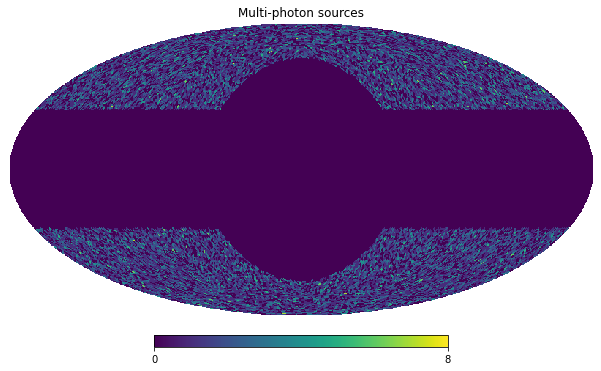

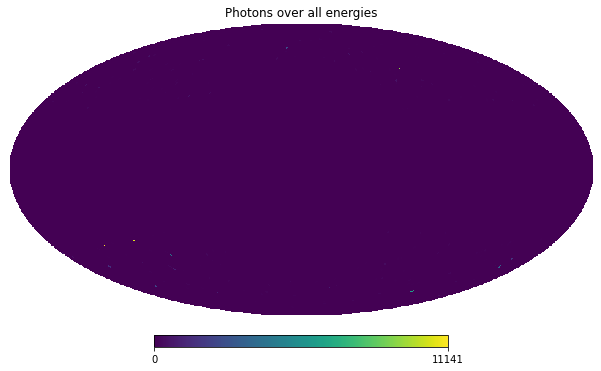

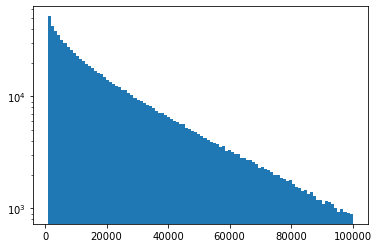

In [8]:
#show data gen
my_lfi.GC_to_earth = 0.
my_lfi.lat_cut = gal_lat_cut
input_params = [200., 1.]
my_lfi.Rmin = 1.0e-30

'''
grains = 1000
massVals = np.geomspace(1.0, 1.0e10, grains)
radiusVals = np.geomspace(my_abc.Rmin, my_abc.Rmax, grains)
def abundance(mass, radius):
    Rs = 21 #scale radius in kpc
    beta = 1.9
    A = 1.2e4
    return A*mass**(-beta)/((radius/Rs)*(1+(radius/Rs))**2)
PDF = abundance(np.tile(massVals[:-1],(grains-1,1)).T, np.tile(radiusVals[:-1],(grains-1,1)))
dM = np.tile(massVals[1:]-massVals[:-1],(grains-1,1)).T
dR = np.tile(radiusVals[1:]-radiusVals[:-1],(grains-1,1))
integrand = PDF*4*np.pi*(np.tile(radiusVals[:-1],(grains-1,1)))**2*dM*dR
print('Number of sources from mass PDF: ', np.sum(integrand))
'''

source_info = my_lfi.create_sources(input_params)
print('Number of sources from lum PDF:  ', np.size(source_info['luminosities']) + np.size(source_info['single_p_distances']))
#print(source_info)
heatmap = np.histogram(hp.ang2pix(N_side, source_info['angles'][:,0], source_info['angles'][:,1]), bins = N_pix, range = [0.0, N_pix])
masked_map = np.zeros(np.size(heatmap[0]))
masked_map[mask_indices] = heatmap[0][mask_indices]
hp.mollview(masked_map, title = 'Multi-photon sources')
photon_info = my_lfi.generate_photons_from_sources(input_params, source_info)
#print(photon_info)
heatmap = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), bins = N_pix, range = [0.0, N_pix])
masked_map = np.zeros(np.size(heatmap[0]))
masked_map[mask_indices] = heatmap[0][mask_indices]
hp.mollview(masked_map, title = 'Photons over all energies')
#hp.mollview(np.log(heatmap[0]))

fig, ax = pl.subplots(1,1)
ax.hist(photon_info['energies'], bins=100)
ax.set_yscale('log')
#ax.set_xscale('log')

0
5
10


 /home/chri3448/.conda/envs/env_healpy/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning:Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


mu =  96.68418375651042
mean count =  10.224638742809555
1063.5260213216145
4752221 52274431.0 49152
0.058514411732954984 0.9594430634469697
0.3023209255913837 0.9999999999999999


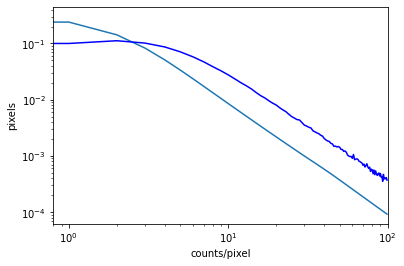

In [9]:
#P(C) plot viewed from GC (Mmin = 1.0e3)
my_lfi.GC_to_earth = 0.001
my_lfi.lat_cut = 0.
my_lfi.Rmax = 220
my_lfi.exposure = (100*2000*0.2*(units.cm.to('kpc')**2)*units.yr.to('s'))#*0.2#*0.241075
input_params = [200., 1.]

many_s_maps = np.array([])
many_p_maps = np.array([])
for i in range(11):
    if i%5==0:
        print(i)
    source_info = my_lfi.create_sources(input_params, grains=3000, epsilon = 0.)
    photon_info = my_lfi.generate_photons_from_sources(input_params, source_info)
    heatmap_s = np.histogram(hp.ang2pix(N_side, source_info['angles'][:,0], source_info['angles'][:,1]), 
                             bins = N_pix, range = [-0.5, N_pix - 0.5])
    heatmap_p = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), 
                             bins = N_pix, range = [-0.5, N_pix - 0.5])
    many_s_maps = np.concatenate((many_s_maps, heatmap_s[0]))
    many_p_maps = np.concatenate((many_p_maps, heatmap_p[0]))
    #many_s_maps = np.concatenate((many_s_maps, heatmap_s[0][mask_indices]))
    #many_p_maps = np.concatenate((many_p_maps, heatmap_p[0][mask_indices]))

skymap_filename = 'skymap_' + suffix + '.pk'
skydict = pk.load(open('../paper2/paper2_data/skymaps/' + skymap_filename, 'rb'))
file = 'pf_and_pc_for_test_Mmin1000.0_physhighMmin_iso_ffthighMmin_iso_withp1f_fixedcentermmin_highexp.pk'
dat = pk.load(open('../data/Test_Data/' + file, 'rb'))

many_s_hist, many_s_bins = np.histogram(many_s_maps, bins = int(max(many_s_maps))+1, range = (0.,max(many_s_maps)+1))
amputated_p_maps = many_p_maps[np.where(many_p_maps<100)]

fig, ax = pl.subplots(1,1)
#ax.plot(skydict['cc_dm'], skydict['pc_dm'], 'k-')
ax.plot(dat['pc'])
many_p_hist, many_p_bins = np.histogram(many_p_maps, bins = int(max(many_p_maps))+1, range = (0.,max(many_p_maps)+1))
amputated_p_hist, amputated_p_bins = np.histogram(amputated_p_maps, bins = int(max(amputated_p_maps))+1, range = (0.,max(amputated_p_maps)+1))
ax.plot(amputated_p_bins[:-1], amputated_p_hist/np.sum(amputated_p_hist), 'b-')
#ax.hist(amputated_p_maps, bins = 100, density = True)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.,100.])
ax.set_xlabel('counts/pixel')
ax.set_ylabel('pixels')

mean_sources = np.sum(many_s_hist*many_s_bins[:-1])/np.sum(many_s_hist)
print('mu = ', mean_sources)
print('mean count = ', np.sum(amputated_p_hist*amputated_p_bins[:-1])/np.sum(amputated_p_hist))
print(np.sum(many_s_maps)/N_pix)
print(np.size(source_info['angles'][:,0]), np.sum(many_s_maps), N_pix)
print(amputated_p_hist[0]/np.sum(amputated_p_hist), np.sum(amputated_p_hist)/np.sum(many_p_hist))
print(dat['pc'][0], np.sum(dat['pc']))


Lower bound on simulated flux:  9.999999999999965e-17
0
expected count/pixel =  7.708960582104748


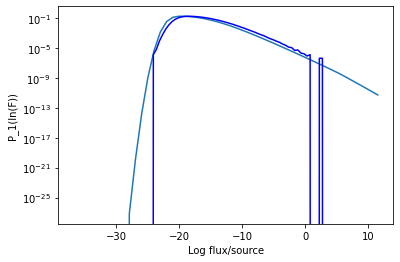

In [18]:
#P_1(F) plot viewed fron GC (Mmin = 1.0e3)
#Number of photons from one source = exposure*FOV*P_1(F) plotted to standardise the bins to expected photons counts
lbound = dat['f_p1f_cm2yr'][0]
print('Lower bound on simulated flux: ', lbound)
fluxes = np.array([])
for i in range(1):
    if i%5==0:
        print(i)
    source_info = my_lfi.create_sources(input_params, grains=2000, epsilon=0.0)
    fluxes = np.concatenate((fluxes, 
                             source_info['luminosities']/units.s.to('yr')/(4*np.pi*(source_info['distances']*units.kpc.to('cm'))**2)))
big_i = np.where(dat['f_p1f_cm2yr'] >= lbound)
flux_hist, flux_bins = np.histogram(np.log(fluxes), bins = np.linspace(np.log(lbound), np.log(np.max(dat['f_p1f_cm2yr'])), 100))
fig, ax = pl.subplots(1,1)
norm_sim = np.sum(flux_hist*(flux_bins[1:]-flux_bins[:-1]))
norm_ana = np.sum(dat['f_p1f_cm2yr'][big_i][:-1]*dat['p1f'][big_i][:-1]*(np.log(dat['f_p1f_cm2yr'][big_i][1:])-np.log(dat['f_p1f_cm2yr'][big_i][:-1])))
'''
flux_hist, flux_bins = np.histogram(np.log(fluxes), bins = np.geomspace(lbound, np.max(dat['f_p1f_cm2yr']), 10))
norm_sim = np.sum(flux_hist*(flux_bins[1:]-flux_bins[:-1]))
ax.plot(dat['f_p1f_cm2yr'][big_i], dat['p1f'][big_i])
ax.plot(flux_bins[:-1], flux_hist/norm_sim, 'b-')
'''
ax.plot(np.log(dat['f_p1f_cm2yr'][big_i]), dat['f_p1f_cm2yr'][big_i]*dat['p1f'][big_i]/norm_ana)
ax.plot(flux_bins[:-1], flux_hist/norm_sim, 'b-')
ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_xlim([0,1.2])
ax.set_xlabel('Log flux/source')
ax.set_ylabel('P_1(ln(F))')

print('expected count/pixel = ', mean_sources*exposure*np.sum(flux_hist*np.exp((flux_bins[1:]+flux_bins[:-1])/2)*(flux_bins[1:]-flux_bins[:-1]))/norm_sim)

0


 /home/chri3448/.conda/envs/env_healpy/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning:Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


0.025472005208333332
0.0683256337634355


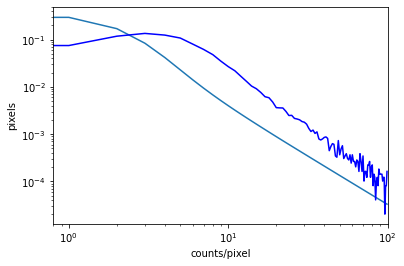

In [15]:
#P(C) plot viewed from GC (Mmin = 1.0)
my_lfi.GC_to_earth = 0.
my_lfi.lat_cut = 0.
input_params = [200., 1.]

many_s_maps = np.array([])
many_p_maps = np.array([])
for i in range(1):
    if i%5==0:
        print(i)
    source_info = my_lfi.create_sources(input_params, grains=4000)
    photon_info = my_lfi.generate_photons_from_sources(input_params, source_info)
    heatmap_s = np.histogram(hp.ang2pix(N_side, source_info['angles'][:,0], source_info['angles'][:,1]), 
                             bins = N_pix, range = [0.0, N_pix])
    heatmap_p = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), 
                             bins = N_pix, range = [0.0, N_pix])
    many_s_maps = np.concatenate((many_s_maps, heatmap_s[0]))
    many_p_maps = np.concatenate((many_p_maps, heatmap_p[0]))
    #many_s_maps = np.concatenate((many_s_maps, heatmap_s[0][mask_indices]))
    #many_p_maps = np.concatenate((many_p_maps, heatmap_p[0][mask_indices]))

skymap_filename = 'skymap_' + suffix + '.pk'
skydict = pk.load(open('../paper2/paper2_data/skymaps/' + skymap_filename, 'rb'))
file = 'pf_and_pc_for_test_Mmin1.0_physisotropic_fftfast_isotropic_withp1f.pk'
dat = pk.load(open('../data/Test_Data/' + file, 'rb'))

many_s_hist, many_s_bins = np.histogram(many_s_maps, bins = int(max(many_s_maps))+1, range = (0.,max(many_s_maps)+1))
amputated_p_maps = many_p_maps[np.where(many_p_maps<100)]

fig, ax = pl.subplots(1,1)
#ax.plot(skydict['cc_dm'], skydict['pc_dm'], 'k-')
ax.plot(dat['pc'])
many_p_hist, many_p_bins = np.histogram(many_p_maps, bins = int(max(many_p_maps))+1, range = (0.,max(many_p_maps)+1))
amputated_p_hist, amputated_p_bins = np.histogram(amputated_p_maps, bins = int(max(amputated_p_maps))+1, range = (0.,max(amputated_p_maps)+1))
ax.plot(amputated_p_bins[:-1], amputated_p_hist/np.sum(many_p_hist), 'b-')
#ax.hist(amputated_p_maps, bins = 100, density = True)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.,100.])
ax.set_xlabel('counts/pixel')
ax.set_ylabel('pixels')

print(np.count_nonzero(many_p_maps == 0.)/np.sum(many_p_hist))
print(skydict['pc_dm'][0])

Lower bound on simulated flux:  0.013894954943731412
0


Text(0, 0.5, 'Ex*P_1(F)')

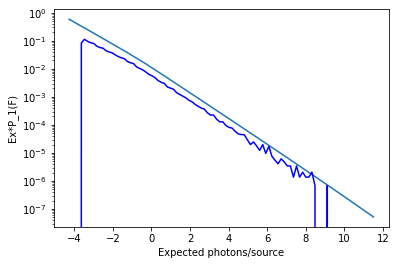

In [29]:
#P_1(F) plot viewed fron GC (Mmin = 1.0)
#Number of photons from one source = exposure*FOV*P_1(F) plotted to standardise the bins to expected photons counts
lbound = dat['f_p1f_cm2yr'][33]
print('Lower bound on simulated flux: ', lbound)
fluxes = np.array([])
for i in range(1):
    if i%5==0:
        print(i)
    source_info = my_lfi.create_sources(input_params, grains=1000, epsilon=lbound)
    fluxes = np.concatenate((fluxes, 
                             exposure*(units.cm.to('kpc')**2)*units.yr.to('s')*source_info['luminosities']/(2*np.pi*source_info['distances']**2)))
big_i = np.where(dat['f_p1f_cm2yr'] >= lbound)
flux_hist, flux_bins = np.histogram(np.log(fluxes), bins = np.linspace(np.log(lbound), np.log(np.max(dat['f_p1f_cm2yr'])), 100))
fig, ax = pl.subplots(1,1)
ax.plot(np.log(dat['f_p1f_cm2yr'][big_i]), dat['f_p1f_cm2yr'][big_i]*dat['p1f'][big_i]/np.sum(dat['f_p1f_cm2yr'][big_i]*dat['p1f'][big_i]))
ax.plot(flux_bins[:-1], flux_hist/np.size(fluxes), 'b-')
ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_xlim([0,1.2])
ax.set_xlabel('Expected photons/source')
ax.set_ylabel('Ex*P_1(F)')

In [11]:
#!only valid when no background present!
my_abc.GC_to_earth = 8.5
my_abc.lat_cut = 0.
my_abc.Rmin = 8.4
input_params = [56.9, 1.]

#generate sources and photons many times
vec = hp.ang2vec(np.pi/2, 0)
min_disc = hp.query_disc(nside=N_side, vec=vec, radius=np.radians(98))
max_disc = hp.query_disc(nside=N_side, vec=vec, radius=np.radians(102))
ring = np.setdiff1d(max_disc, min_disc)

many_s_maps = np.array([])
many_p_maps = np.array([])
for i in range(50):
    if i%5==0:
        print(i)
    source_info = my_abc.create_sources(input_params, grains=500)
    photon_info = my_abc.generate_photons_from_sources(input_params, source_info)
    heatmap_s = np.histogram(hp.ang2pix(N_side, source_info['angles'][:,0], source_info['angles'][:,1]), 
                             bins = N_pix, range = [0.0, N_pix])
    heatmap_p = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), 
                             bins = N_pix, range = [0.0, N_pix])
    many_s_maps = np.concatenate((many_s_maps, heatmap_s[0][ring]))
    many_p_maps = np.concatenate((many_p_maps, heatmap_p[0][ring]))
    
heatmap_s[0][ring] = heatmap_s[0].max()
hp.mollview(heatmap_s[0])
heatmap_p[0][ring] = heatmap_p[0].max()
hp.mollview(heatmap_p[0])

0


 /home/chri3448/EPDF_ABC/EPDFABC.py:128: RuntimeWarning:invalid value encountered in true_divide


5
10


KeyboardInterrupt: 

 /home/chri3448/.conda/envs/env_healpy/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning:Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67.]
7.0
mu =  0.815251461988304
0.8628771929824561
0.8547563156176141
0.9999298245614036
1.00136765494958
[4.43520468e-01 3.60865497e-01 1.44982456e-01 4.02456140e-02
 8.50292398e-03 1.64912281e-03 2.10526316e-04 2.33918129e-05]
[8.62877193e-01 1.18748538e-01 1.25380117e-02 2.35087719e-03
 1.12280702e-03 4.56140351e-04 2.57309942e-04 2.22222222e-04
 1.75438596e-04 1.63742690e-04 9.35672515e-05 8.18713450e-05
 5.84795322e-05 1.05263158e-04 4.67836257e-05 5.84795322e-05
 4.67836257e-05 2.33918129e-05 5.84795322e-05 0.00000000e+00
 4.67836257e-05 0.00000000e+00 1.16959064e-05 1.16959064e-05
 3.50877193e-05 1.16959064e-05 4.67836257e-05 1.16959064e-05
 1.16959064e-05 1.16959064e-05 0.00000000e+00 2.33918129e-05
 1.1695906

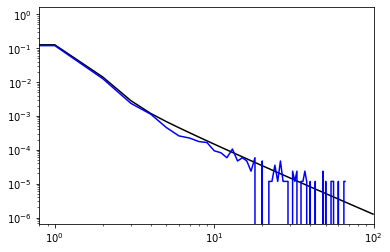

In [9]:
#!only valid when no background present!
#many_maps = pk.load(open('./data/Test_Data/many_maps.pk','rb'))
#amputated_maps = pk.load(open('./data/Test_Data/amputated_maps.pk','rb'))
many_s_hist, many_s_bins = np.histogram(many_s_maps, bins = int(max(many_s_maps))+1, range = (0.,max(many_s_maps)+1))
amputated_p_maps = many_p_maps[np.where(many_p_maps<100)]
testdata = pk.load(open('./data/Test_Data/pf_and_pc_for_test_Mmin1.0.pk','rb'))
fig, ax = pl.subplots(1,1)
ax.plot(testdata['counts'], testdata['pc'], 'k-')
many_p_hist, many_p_bins = np.histogram(many_p_maps, bins = int(max(many_p_maps))+1, range = (0.,max(many_p_maps)+1))
amputated_p_hist, amputated_p_bins = np.histogram(amputated_p_maps, bins = int(max(amputated_p_maps))+1, range = (0.,max(amputated_p_maps)+1))
ax.plot(amputated_p_bins[:-1], amputated_p_hist/np.sum(many_p_hist), 'b-')
#ax.hist(amputated_p_maps, bins = 100, density = True)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.,100.])
print(amputated_p_bins)
print(max(many_s_maps))
print('mu = ', np.sum(many_s_hist*many_s_bins[:-1]/np.sum(many_s_hist)))
print(np.count_nonzero(many_p_maps == 0.)/np.sum(many_p_hist))
print(testdata['pc'][0])
print(np.sum(amputated_p_hist)/np.sum(many_p_hist))
print(np.sum(testdata['pc']))
print(many_s_hist/np.sum(many_s_hist))
print(amputated_p_hist/np.sum(many_p_hist))
print(testdata['pc'])

 /home/chri3448/EPDF_ABC/EPDFABC.py:128: RuntimeWarning:invalid value encountered in true_divide
Running 100 simulations.: 100%|██████████| 100/100 [02:09<00:00,  1.29s/it]


 Neural network successfully converged after 64 epochs.

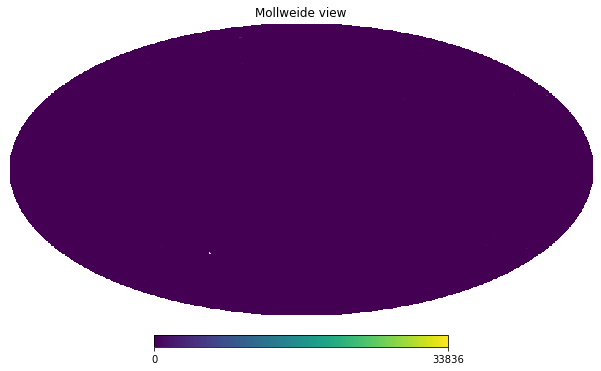

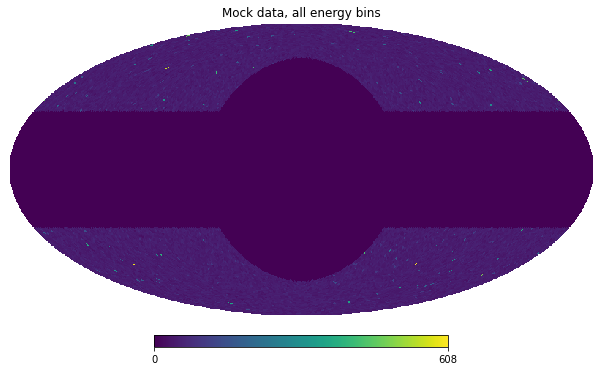

In [8]:
#sbi
input_params = [200., 1.]
my_abc.Rmin = 0.21
def simulator(inputs):
    my_abc.GC_to_earth = 0.
    my_abc.lat_cut = gal_lat_cut
    source_info = my_abc.create_sources(inputs)
    photon_info = my_abc.generate_photons_from_sources(inputs, source_info)
    heatmap = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), bins = N_pix, range = [0.0, N_pix])
    masked_map = np.zeros(np.size(heatmap[0]))
    masked_map[mask_indices] = heatmap[0][mask_indices]
    return masked_map

test_map = simulator(input_params)
hp.mollview(test_map)

prior = utils.BoxUniform(low = param_min, high = param_max)
posterior = infer(simulator, prior, method='SNPE', num_simulations=100)

skymap_filename = 'skymap_' + suffix + '.pk'
skydict = pk.load(open('./paper2/paper2_data/skymaps/' + skymap_filename, 'rb'))
obs_data = np.expand_dims(np.sum(skydict['obs_data'],axis=2),axis=2)
map_to_plot = np.zeros(len(skydict['mask']))
mask_indices = np.where(skydict['mask'] > 0)[0]
map_to_plot[mask_indices] = obs_data[0,:,0]
hp.mollview(map_to_plot, title = 'Mock data, all energy bins')
#observation = map_to_plot
observation = test_map

Drawing 100000 posterior samples: 102038it [04:34, 371.07it/s]                           


(<Figure size 432x432 with 4 Axes>,
 array([[<AxesSubplot:xlabel='dim 1'>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:xlabel='dim 2'>]], dtype=object))

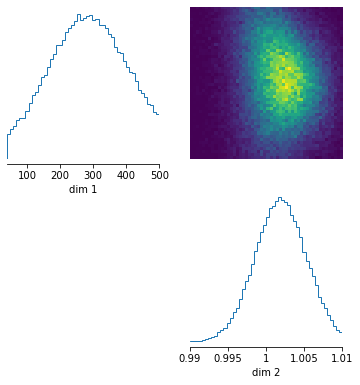

In [10]:
samples = posterior.sample((100000,), x=observation)
#log_probability = posterior.log_prob(samples, x=observation)
analysis.pairplot(samples, limits=[[param_min[0],param_max[0]],[param_min[1],param_max[1]]], figsize=(6,6))